## **Introduction to Image Processing**

Mojdeh Rastgoo - Desire Sidibe

## 3. Interpolation and Blending

 Importing necessary libraries/modules and functions

In [4]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from PIL import Image


Pretty printing has been turned ON


### 3.1  Resizing an image size using different interpolation functions

** Q.1 Resize the `lena` or `vibot` image using nearest, bilinear and bicubic function.** 

You can define your function which accept the model and resize size from the user or just run a script.

In [5]:
path = './images/'
Image_name ='lena-grey.bmp'
lena = io.imread(path.__add__(Image_name))
lena_im_float = img_as_float(Image)


ValueError: Can not convert from object to float64.

In [6]:
def ImRezise(im , method='nearest',size=0.5):
    print('The resize method is {}'.format(method))
    im_resize = misc.imresize(im,size,method)
    return im_resize

In [7]:
resized_lena_nearest = ImRezise(lena_im_float)
io.imshow(resized_lena_nearest)
resized_lena_bilinear = ImRezise(lena_im_float,method='bilinear')
io.imshow(resized_lena_bilinear)
resized_lena_bicubic = ImRezise(lena_im_float,method='bicubic')
io.imshow(resized_lena_bicubic)


NameError: name 'lena_im_float' is not defined

**Q.2 Write three functions that performs `simple_blend`, `alpha_blend` and `pyramid_blend`**

** Using your functions, blend `orange` and `apple` images together.**


In [8]:
def BlendImg_simple(image0,image1):
    right_side = image0[:,0:int((len(image0[1])/2-1))]
    lefto_side = image1[:,int((len(image1[1])/2-1)):int((len(image1[1])))]
    new_img = np.empty((300,300,3))
    new_img[:,0:int((len(new_img[1])/2)),:] = float_apple[:,0:int((len(float_apple[1])/2)),:]
    new_img[:,int((len(new_img[1])/2)):int((len(new_img[1])))] = float_orange[:,int((len(float_orange[1])/2)):int((len(float_orange[1])))]

    return new_img

In [9]:
apple ='apple.jpeg'
apple = io.imread(path.__add__(apple))
float_apple = img_as_float(apple)
orange ='orange.jpeg'
orange = io.imread(path.__add__(orange))
float_orange = img_as_float(orange)


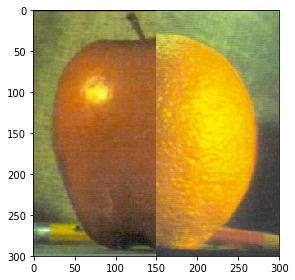

In [10]:
io.imshow(BlendImg_simple(float_apple,float_orange))

In [12]:
overlap = (float_apple + float_orange)
normalized = overlap / np.maximum(overlap, 1)

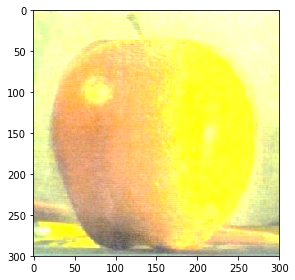

In [16]:
io.imshow(normalized)